In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, gamma, aggregate_risk, corr=None, rho=None):
        self.n = n
        self.corr = corr
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)
        
        
    def MC_multi_data(self):
        self.brownian_ = np.random.multivariate_normal(np.zeros([self.corr.shape[0]]), self.corr, size=(self.n, self.period+2))
        self.market_ = self.brownian_[:, 0, 1:]
        self.hc_ = self.aggregate_risk*self.brownian_[:, :, :1].reshape(self.n, self.period+2)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        self.after_retire_H_t = np.exp(fixed_effect_coeff) / (dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = self.after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (self.after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
        
        
    def get_multiasset_ret(self, asset_data, freq_multiplyer=1, mu_adj=False):
        self.asset_mu = asset_data.mean().values * freq_multiplyer
        if mu_adj is True:
            self.asset_mu[:-4] = self.asset_mu[:-4] / 2
        self.asset_std = asset_data.std().values * np.sqrt(freq_multiplyer)
        
        self.R_t = np.exp(np.ones(self.market_.shape)*self.asset_mu + (0.5*(np.ones(self.market_.shape)*self.asset_std)**2) + (self.asset_std*self.market_))
    
    
    def fit(self, weight_constraint=False):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)
            
            eta = (self.corr[0][1:] * (self.asset_mu - self.asset_mu[-1])) @ weight
            dc_rate = np.exp((self.asset_mu[-1] + 0.04 + eta) * (np.array(range(self.period+1)) + 1) * (-1))
            
            if self.period == 0:
                self.H_t = self.labor_income / dc_rate[0]
            
                if self.gamma == 1:
                    obj = np.log(W_t+self.H_t) * (-1)
                else:
                    obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            else:
                self.H_t = self.labor_income @ dc_rate + (self.after_retire_H_t * dc_rate[-1])
                
                if self.gamma == 1:
                    obj = np.log(W_t+self.H_t) * (-1)
                else:
                    obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)     
                    
            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        if weight_constraint is False:
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                    {'type': 'ineq', 'fun': lambda x: x},)
        else:
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                    {'type': 'ineq', 'fun': lambda x: x},
                    {'type': 'ineq', 'fun': lambda x: 0.25 - x},)
        
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons, options={"maxiter":5000})
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    lc_df = lc_df.copy().cumsum(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    plt.fill_between(lc_df.index, lc_df[lc_df.columns[0]])
    for i in range(lc_df.columns.shape[0]-1):
        plt.fill_between(lc_df.index, lc_df[lc_df.columns[i]], lc_df[lc_df.columns[i+1]])
    plt.legend(lc_df.columns)
    plt.ylim(0, 100)
    plt.show()

In [5]:
def lc_multiasset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4, weight_constraint=False, mu_adj=False):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, corr=group_characherize_data["corr_mat"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)
            
        model.MC_multi_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_multiasset_ret(asset_dic, freq_multiplyer=12, mu_adj=False)
        opt_weights = model.fit(weight_constraint=weight_constraint)

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=asset_dic.columns) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df

## University edu levels with Multi-asset (rho=6)
_______________

In [59]:
asset_data.mean()*12

대한민국 - KOSPI       0.109867
독일 DAX             0.102329
영국 FTSE 100        0.048319
러셀 3000            0.073757
국고채 총수익 지수         0.040333
국고채 콜 재투자 지수       0.039422
국고채 제로 재투자 지수      0.037844
KRW Cash 총수익 지수    0.024493
dtype: float64

In [60]:
asset_data.std()*np.sqrt(12)

대한민국 - KOSPI       0.289558
독일 DAX             0.221804
영국 FTSE 100        0.142978
러셀 3000            0.154197
국고채 총수익 지수         0.023799
국고채 콜 재투자 지수       0.022364
국고채 제로 재투자 지수      0.022368
KRW Cash 총수익 지수    0.002868
dtype: float64

In [53]:
asset_data = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\oversea_return_monthly(5_index_without_nasdaq).xlsx", index_col=0) / 100
corr_mat = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\oversea_corr(5_index_without_nasdaq).xlsx", index_col=0)

In [7]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [8]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [9]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [10]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3207.0,3368.0,3534.0,3692.0,3871.0,4023.0,4210.0,4377.0,4551.0,...,6237.0,6205.0,6256.0,6226.0,6234.0,6200.0,6135.0,6061.0,6028.0,5928.0
financial_wealth,1000.0,2161.0,3500.0,5033.0,6774.0,8758.0,11004.0,13499.0,16351.0,19525.0,...,251376.0,289249.0,331766.0,379739.0,433892.0,495858.0,565250.0,641614.0,729160.0,826284.0


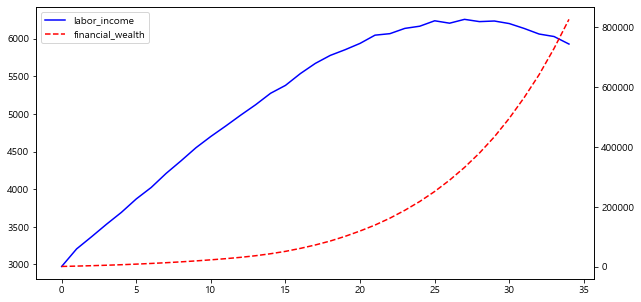

In [11]:
data_plotting(lc_data)

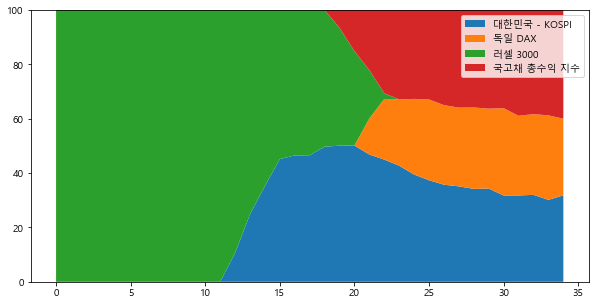

In [12]:
lc_weights_plot(lc_weights)

In [54]:
corr_mat

,university,대한민국 - KOSPI,독일 DAX,영국 FTSE 100,러셀 3000,국고채 총수익 지수,국고채 콜 재투자 지수,국고채 제로 재투자 지수,KRW Cash 총수익 지수
university,1.000000,-0.012220,0.046925,-0.014368,-0.115035,-0.240676,-0.230896,-0.233980,0.044229
대한민국 - KOSPI,-0.012220,1.000000,0.627000,0.663290,0.555705,-0.476768,-0.474082,-0.471153,-0.086017
독일 DAX,0.046925,0.627000,1.000000,0.916633,0.863210,-0.456532,-0.451282,-0.453166,0.055133
영국 FTSE 100,-0.014368,0.663290,0.916633,1.000000,0.919927,-0.560185,-0.554563,-0.554810,-0.075208
러셀 3000,-0.115035,0.555705,0.863210,0.919927,1.000000,-0.487033,-0.483137,-0.480390,0.013161
국고채 총수익 지수,-0.240676,-0.476768,-0.456532,-0.560185,-0.487033,1.000000,0.999561,0.999086,0.338432
국고채 콜 재투자 지수,-0.230896,-0.474082,-0.451282,-0.554563,-0.483137,0.999561,1.000000,0.999597,0.352718
국고채 제로 재투자 지수,-0.233980,-0.471153,-0.453166,-0.554810,-0.480390,0.999086,0.999597,1.000000,0.357308
KRW Cash 총수익 지수,0.044229,-0.086017,0.055133,-0.075208,0.013161,0.338432,0.352718,0.357308,1.000000


In [13]:
lc_weights.index = lc_weights.index+26
lc_weights

,대한민국 - KOSPI,독일 DAX,러셀 3000,국고채 총수익 지수
26,0.00,0.00,100.00,0.00
27,0.00,0.00,100.00,0.00
28,0.00,0.00,100.00,0.00
29,0.00,0.00,100.00,0.00
30,0.00,0.00,100.00,0.00
31,0.00,0.00,100.00,0.00
32,0.00,0.00,100.00,0.00
33,0.00,0.00,100.00,0.00
34,0.00,0.00,100.00,0.00
35,0.00,0.00,100.00,0.00


## College edu levels with Multi-asset (rho=6)
_______________

In [55]:
asset_data = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\oversea_return_monthly(5_index_without_nasdaq).xlsx", index_col=0) / 100
corr_mat = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\oversea_corr_college(5_index_without_nasdaq).xlsx", index_col=0)

In [15]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.145682+0.010166), 
                           "fixed_effect_coeff":[7.8016-2.3326+0.2550+0.0537*2], "age_coeff_list":[0.1232, -0.0193, 0.0011], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8016-2.3326+0.2550+0.0537*2 + (25 * 0.1232 + ((25**2 /10) * -0.0193) + ((25**3/100) * 0.0011)))}

In [16]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [17]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [18]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2636.0,2855.0,2983.0,3122.0,3250.0,3393.0,3505.0,3642.0,3781.0,3905.0,...,5491.0,5527.0,5626.0,5684.0,5767.0,5818.0,5863.0,5907.0,5986.0,6029.0
financial_wealth,1000.0,1934.0,2947.0,4044.0,5230.0,6508.0,7875.0,9345.0,10916.0,12742.0,...,126854.0,145290.0,166406.0,190559.0,218151.0,249874.0,285668.0,325041.0,370318.0,420599.0


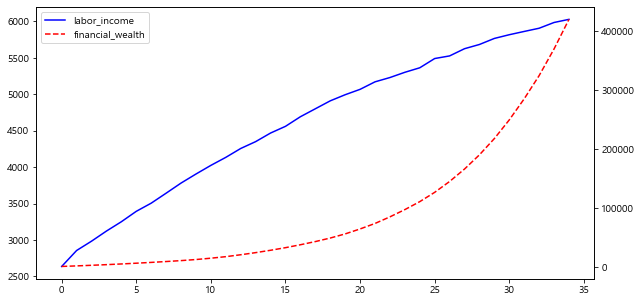

In [19]:
data_plotting(lc_data)

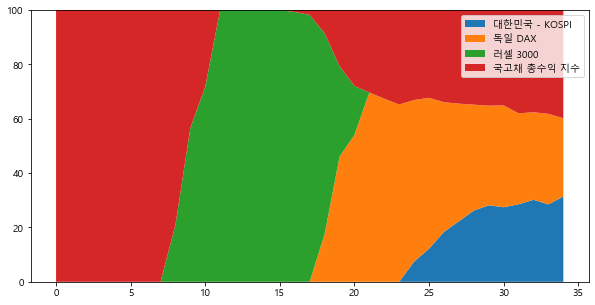

In [20]:
lc_weights_plot(lc_weights)

In [56]:
corr_mat

,college,대한민국 - KOSPI,독일 DAX,영국 FTSE 100,러셀 3000,국고채 총수익 지수,국고채 콜 재투자 지수,국고채 제로 재투자 지수,KRW Cash 총수익 지수
college,1.000000,0.333802,0.049623,0.013794,-0.020596,-0.128835,-0.125889,-0.132845,0.021813
대한민국 - KOSPI,0.333802,1.000000,0.627000,0.663290,0.555705,-0.476768,-0.474082,-0.471153,-0.086017
독일 DAX,0.049623,0.627000,1.000000,0.916633,0.863210,-0.456532,-0.451282,-0.453166,0.055133
영국 FTSE 100,0.013794,0.663290,0.916633,1.000000,0.919927,-0.560185,-0.554563,-0.554810,-0.075208
러셀 3000,-0.020596,0.555705,0.863210,0.919927,1.000000,-0.487033,-0.483137,-0.480390,0.013161
국고채 총수익 지수,-0.128835,-0.476768,-0.456532,-0.560185,-0.487033,1.000000,0.999561,0.999086,0.338432
국고채 콜 재투자 지수,-0.125889,-0.474082,-0.451282,-0.554563,-0.483137,0.999561,1.000000,0.999597,0.352718
국고채 제로 재투자 지수,-0.132845,-0.471153,-0.453166,-0.554810,-0.480390,0.999086,0.999597,1.000000,0.357308
KRW Cash 총수익 지수,0.021813,-0.086017,0.055133,-0.075208,0.013161,0.338432,0.352718,0.357308,1.000000


In [21]:
lc_weights.index = lc_weights.index+26
lc_weights

,대한민국 - KOSPI,독일 DAX,러셀 3000,국고채 총수익 지수
26,0.00,0.00,0.00,100.00
27,0.00,0.00,0.00,100.00
28,0.00,0.00,0.00,100.00
29,0.00,0.00,0.00,100.00
30,0.00,0.00,0.00,100.00
31,0.00,0.00,0.00,100.00
32,0.00,0.00,0.00,100.00
33,0.00,0.00,0.00,100.00
34,0.00,0.00,20.89,79.11
35,0.00,0.00,56.56,43.44


## High_school edu levels with Multi-asset (rho=6)
_______________

In [34]:
asset_data = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\oversea_return_monthly(5_index_without_nasdaq).xlsx", index_col=0) / 100
corr_mat = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\oversea_corr_high(5_index_without_nasdaq).xlsx", index_col=0)

In [35]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.174855+0.005461), 
                           "fixed_effect_coeff":[7.5072-0.7417+0.3198+0.059*2], "age_coeff_list":[0.0124, 0.0064, -0.0009], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.5072-0.7417+0.3198+0.059*2 + (25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009)))}

In [45]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [46]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [47]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2375.0,2602.0,2671.0,2751.0,2816.0,2904.0,2967.0,3047.0,3145.0,3223.0,...,4367.0,4388.0,4447.0,4470.0,4504.0,4519.0,4509.0,4489.0,4502.0,4470.0
financial_wealth,1000.0,1855.0,2767.0,3741.0,4779.0,5885.0,7058.0,8308.0,9636.0,11044.0,...,49049.0,54596.0,61144.0,68850.0,77652.0,88299.0,100770.0,114758.0,131080.0,149365.0


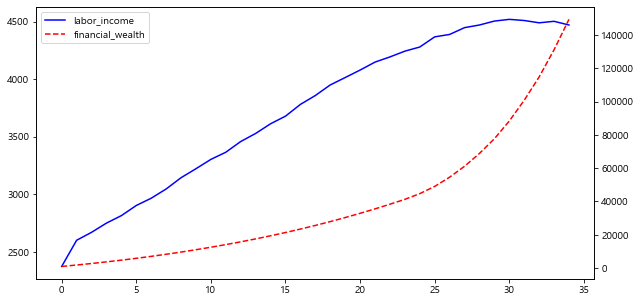

In [48]:
data_plotting(lc_data)

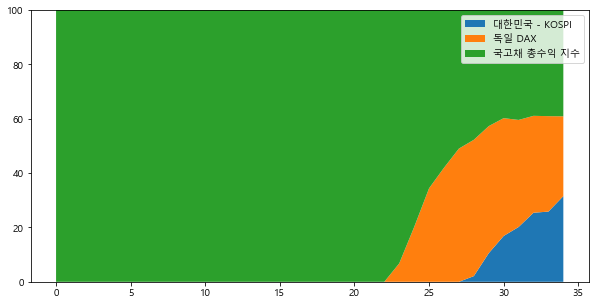

In [49]:
lc_weights_plot(lc_weights)

In [52]:
lc_weights.index = lc_weights.index+26
lc_weights

,대한민국 - KOSPI,독일 DAX,국고채 총수익 지수
26,0.00,0.00,100.00
27,0.00,0.00,100.00
28,0.00,0.00,100.00
29,0.00,0.00,100.00
30,0.00,0.00,100.00
31,0.00,0.00,100.00
32,0.00,0.00,100.00
33,0.00,0.00,100.00
34,0.00,0.00,100.00
35,0.00,0.00,100.00


In [50]:
asset_data.mean() * 12

대한민국 - KOSPI       0.109867
독일 DAX             0.102329
영국 FTSE 100        0.048319
러셀 3000            0.073757
국고채 총수익 지수         0.040333
국고채 콜 재투자 지수       0.039422
국고채 제로 재투자 지수      0.037844
KRW Cash 총수익 지수    0.024493
dtype: float64

In [51]:
asset_data.std() * np.sqrt(12)

대한민국 - KOSPI       0.289558
독일 DAX             0.221804
영국 FTSE 100        0.142978
러셀 3000            0.154197
국고채 총수익 지수         0.023799
국고채 콜 재투자 지수       0.022364
국고채 제로 재투자 지수      0.022368
KRW Cash 총수익 지수    0.002868
dtype: float64

In [44]:
corr_mat

,high_school,대한민국 - KOSPI,독일 DAX,영국 FTSE 100,러셀 3000,국고채 총수익 지수,국고채 콜 재투자 지수,국고채 제로 재투자 지수,KRW Cash 총수익 지수
high_school,1.000000,0.632348,0.195925,0.222525,0.205978,-0.427067,-0.422141,-0.419593,0.071798
대한민국 - KOSPI,0.632348,1.000000,0.627000,0.663290,0.555705,-0.476768,-0.474082,-0.471153,-0.086017
독일 DAX,0.195925,0.627000,1.000000,0.916633,0.863210,-0.456532,-0.451282,-0.453166,0.055133
영국 FTSE 100,0.222525,0.663290,0.916633,1.000000,0.919927,-0.560185,-0.554563,-0.554810,-0.075208
러셀 3000,0.205978,0.555705,0.863210,0.919927,1.000000,-0.487033,-0.483137,-0.480390,0.013161
국고채 총수익 지수,-0.427067,-0.476768,-0.456532,-0.560185,-0.487033,1.000000,0.999561,0.999086,0.338432
국고채 콜 재투자 지수,-0.422141,-0.474082,-0.451282,-0.554563,-0.483137,0.999561,1.000000,0.999597,0.352718
국고채 제로 재투자 지수,-0.419593,-0.471153,-0.453166,-0.554810,-0.480390,0.999086,0.999597,1.000000,0.357308
KRW Cash 총수익 지수,0.071798,-0.086017,0.055133,-0.075208,0.013161,0.338432,0.352718,0.357308,1.000000
